# Atlanta Police Department
![APD Logo](https://atlantapd.galls.com/photos/partners/atlantapd/logo.jpg)


The Atlanta Police Department provides Part 1 crime data at http://www.atlantapd.org/i-want-to/crime-data-downloads

A recent copy of the data file is stored in the cluster. <span style="color: red; font-weight: bold;">Please, do not copy this data file into your home directory!</span>

# Introduction


- This notebooks leads into an exploration of public crime data provided by the Atlanta Police Department.
- The original data set and supplemental information can be found at http://www.atlantapd.org/i-want-to/crime-data-downloads
- **The data set is available on ARC, please, don't download into your home directory on ARC!**

In [2]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# load data set
df = pd.read_csv('/home/data/APD/COBRA-YTD-multiyear.csv.gz')
print "Shape of table: ", df.shape

Shape of table:  (285733, 23)


/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Review: Creating a data key

Let's look at the structure of this table. We're actually creating some text output that can be used to create a data dictionary.

In [4]:
dataDict = pd.DataFrame({'DataType': df.dtypes.values, 'Description': '', }, index=df.columns.values)

We need to enter the descriptions for each entry in our dictionary manually...

In [6]:
dataDict.loc['MI_PRINX'].Description = '' # type: int64
dataDict.loc['offense_id'].Description = 'Unique ID in the format YYDDDNNNN with the year YY, the day of the year DDD and a counter NNNN' # type: int64
dataDict.loc['rpt_date'].Description = 'Date the crime was reported' # type: object
dataDict.loc['occur_date'].Description = 'Estimated date when the crime occured' # type: object
dataDict.loc['occur_time'].Description = 'Estimated time when the crime occured' # type: object
dataDict.loc['poss_date'].Description = '' # type: object
dataDict.loc['poss_time'].Description = '' # type: object
dataDict.loc['beat'].Description = '' # type: int64
dataDict.loc['apt_office_prefix'].Description = '' # type: object
dataDict.loc['apt_office_num'].Description = '' # type: object
dataDict.loc['location'].Description = '' # type: object
dataDict.loc['MinOfucr'].Description = '' # type: int64
dataDict.loc['MinOfibr_code'].Description = '' # type: object
dataDict.loc['dispo_code'].Description = '' # type: object
dataDict.loc['MaxOfnum_victims'].Description = '' # type: float64
dataDict.loc['Shift'].Description = 'Zones have 8 or 10 hour shifts' # type: object
dataDict.loc['Avg Day'].Description = '' # type: object
dataDict.loc['loc_type'].Description = '' # type: float64
dataDict.loc['UC2 Literal'].Description = '' # type: object
dataDict.loc['neighborhood'].Description = '' # type: object
dataDict.loc['npu'].Description = '' # type: object
dataDict.loc['x'].Description = '' # type: float64
dataDict.loc['y'].Description = '' # type: float64
dataDict.to_csv("COBRA_Data_Dictionary.csv")

In [7]:
dataDict

,DataType,Description
MI_PRINX,int64,
offense_id,int64,Unique ID in the format YYDDDNNNN with the yea...
rpt_date,object,Date the crime was reported
occur_date,object,Estimated date when the crime occured
occur_time,object,Estimated time when the crime occured
poss_date,object,
poss_time,object,
beat,float64,
apt_office_prefix,object,
apt_office_num,object,


## Convert Time Columns

Please refer to the following resources for working with time series data in pandas:
- https://pandas.pydata.org/pandas-docs/stable/timeseries.html
- https://pandas.pydata.org/pandas-docs/stable/api.html#id10

In [10]:
# function currying
def fixdatetime(fld):
    def _fix(s):
        date_col = '%s_date' % fld # "rpt_date"
        time_col = '%s_time' % fld # "rpt_time"
        if time_col in s.index:
            return str(s[date_col])+' '+str(s[time_col])
        else:
            return str(s[date_col])+' 00:00:00'
    return _fix

In [11]:
for col in ['rpt', 'occur', 'poss']:
    datser = df.apply(fixdatetime(col), axis=1)
    df['%s_dt'%col] = pd.to_datetime(datser, format="%m/%d/%Y %H:%M:%S", errors='coerce')

In [12]:
df[["MI_PRINX", "offense_id", "beat", "UC2 Literal", "neighborhood", "rpt_dt", "occur_dt", "poss_dt"]].head()

,MI_PRINX,offense_id,beat,UC2 Literal,neighborhood,rpt_dt,occur_dt,poss_dt
0,1160569,90360664,305.0,LARCENY-NON VEHICLE,South Atlanta,2009-02-05,2009-02-03 13:50:00,2009-02-03 15:00:00
1,1160570,90370891,502.0,LARCENY-FROM VEHICLE,Ansley Park,2009-02-06,2009-02-06 08:50:00,2009-02-06 10:45:00
2,1160572,91681984,604.0,LARCENY-NON VEHICLE,Sweet Auburn,2009-06-17,2009-06-17 14:00:00,2009-06-17 15:00:00
3,1160575,82040835,104.0,BURGLARY-RESIDENCE,Mozley Park,2009-02-27,2008-07-21 18:00:00,2008-07-21 18:00:00
4,1160576,82922120,210.0,AUTO THEFT,Lenox,2009-01-14,2008-10-19 18:30:00,2008-10-19 19:45:00


What's the date range of the data?

In [13]:
print df.occur_dt.min(), '---', df.occur_dt.max()

1916-01-07 12:15:00 --- 2017-09-28 02:07:00


Number of crimes reported each year:

In [14]:
# resample is like "groupby" for time
df.resample('A-DEC', closed='right', on='occur_dt').offense_id.count()
# df['Year'] = df.occur_dt.map(lambda d: d.year)
# df2 = df[(df.Year>=2010) & (df.Year<=2017)]
# df2.shape, df.shape

occur_dt
1916-12-31       11
1917-12-31        0
1918-12-31        0
1919-12-31        0
1920-12-31        2
1921-12-31        0
1922-12-31        0
1923-12-31        0
1924-12-31        0
1925-12-31        0
1926-12-31        0
1927-12-31        0
1928-12-31        0
1929-12-31        0
1930-12-31        0
1931-12-31        0
1932-12-31        0
1933-12-31        0
1934-12-31        0
1935-12-31        0
1936-12-31        0
1937-12-31        0
1938-12-31        0
1939-12-31        0
1940-12-31        0
1941-12-31        0
1942-12-31        0
1943-12-31        0
1944-12-31        0
1945-12-31        0
              ...  
1988-12-31        0
1989-12-31        0
1990-12-31        0
1991-12-31        2
1992-12-31        0
1993-12-31        1
1994-12-31        1
1995-12-31        0
1996-12-31        2
1997-12-31        0
1998-12-31        1
1999-12-31        0
2000-12-31        3
2001-12-31        5
2002-12-31        3
2003-12-31        2
2004-12-31        4
2005-12-31        4
2006-12-31 

Looks like most of the data is actually from 2009-2017! Let's throw the rest away...

In [15]:
df = df[df.occur_dt>='01/01/2009']

# Crime Over Time

Has the number of crimes in Atlanta changed over time?

Are some areas more affected by crime than others?

Do different types of crime correlate with each other?

## Number of Crimes Over Time, with Pivot Tables

In [39]:
df[["occur_dt", "UC2 Literal", "offense_id"]].head()

,occur_dt,UC2 Literal,offense_id
0,2009-02-03 13:50:00,LARCENY-NON VEHICLE,90360664
1,2009-02-06 08:50:00,LARCENY-FROM VEHICLE,90370891
2,2009-06-17 14:00:00,LARCENY-NON VEHICLE,91681984
13,2009-01-01 00:10:00,BURGLARY-RESIDENCE,90010061
18,2009-01-01 00:57:00,ROBBERY-PEDESTRIAN,90010159


In [115]:
# Pivoting the table:
# index = nolumn that the new table will be indexed by
# columns = column whose unique values will form the new column names
# values = values used to fill the table (default = all columns other than those given in index and columns)
df_ct = df.pivot_table(index="occur_dt", columns="UC2 Literal", values="offense_id")

In [116]:
df_ct.head()

UC2 Literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,RAPE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
occur_dt,,,,,,,,,,,
2009-01-01 00:00:00,153221163.0,NaN,NaN,91560871.0,NaN,NaN,110261152.0,NaN,NaN,NaN,NaN
2009-01-01 00:01:00,NaN,90011439.0,NaN,91681133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:10:00,NaN,NaN,NaN,90010061.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:15:00,NaN,90010545.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:30:00,NaN,90010358.0,90140681.0,NaN,NaN,90020660.0,90030641.0,NaN,NaN,NaN,NaN


This gives us a timeline for different types of crime reported in Atlanta.

By itself, this can be useful, but we are more interested in aggregate statistics. Let's get the number of crimes by month...

In [117]:
df_ct = df_ct.resample("1M", closed="right").count()

In [113]:
df_ct.head()

UC2 Literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,RAPE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
occur_dt,,,,,,,,,,,
2009-01-31,215,429,193,546,6,705,599,12,26,204,28
2009-02-28,197,334,110,385,9,600,536,7,14,104,19
2009-03-31,225,385,98,448,5,619,613,7,22,139,28
2009-04-30,224,406,124,495,5,610,616,8,26,118,22
2009-05-31,218,454,163,519,8,751,595,12,16,151,21


Average number of crimes per month, for each year:

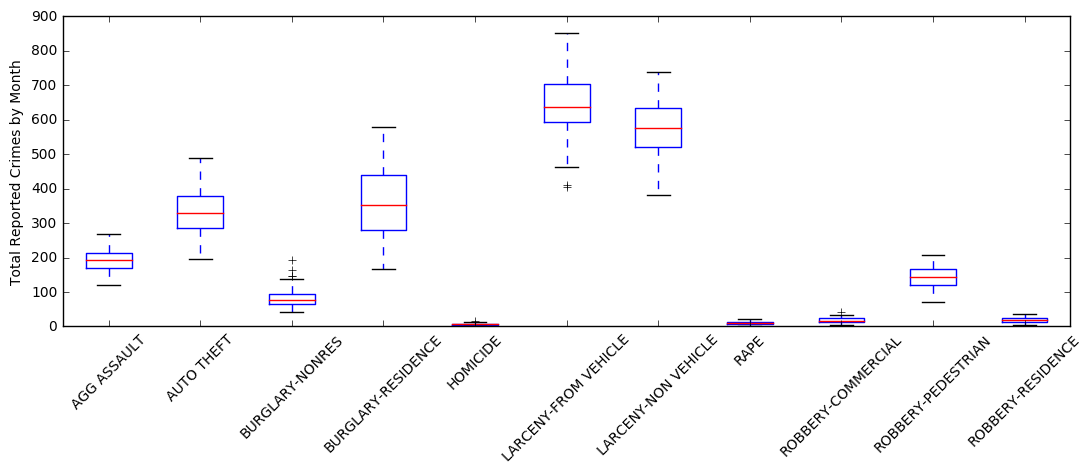

In [56]:
ax = df_ct.plot.box(figsize=(13,4), rot=45)
plt.ylabel("Total Reported Crimes by Month")

Explanation of boxplot:

From the matplotlib documentation (http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.boxplot):

The box extends from the **lower to upper quartile values** of the data, with a line at the **median**. The whiskers extend from the box to show the range of the data. Flier points are those past the end of the whiskers.

**Whiskers:** IQR is the interquartile range (Q3-Q1). The upper whisker will extend to last datum less than Q3 + whis*IQR (where the default value for whis is 1.5). Similarly, the lower whisker will extend to the first datum greater than Q1 - whis*IQR. Beyond the whiskers, data are considered outliers and are plotted as individual points. 

In [70]:
## In-class exercise:
# Make a boxplot of the number of reported crimes, aggregating by week. 

### Crimes over time

Let's take a look at a time series plot of the number of crimes over time...

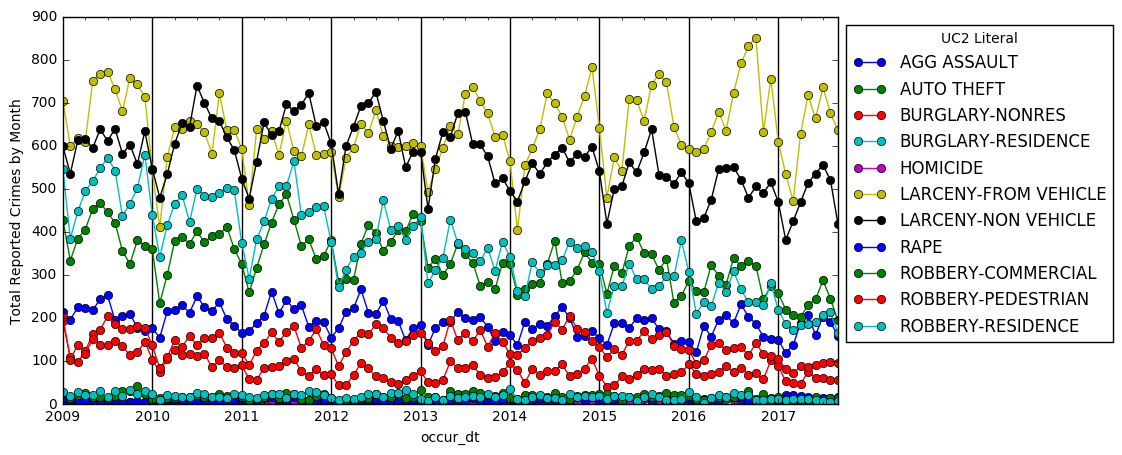

In [69]:
ax = df_ct.plot(figsize=(10,5), style='-o')
ax.get_legend().set_bbox_to_anchor((1, 1))
plt.ylabel("Total Reported Crimes by Month")
ax.vlines(pd.date_range("12/31/2009", "12/31/2017", freq="A-JAN"), 0, 900)

Can you pick out the seasonal variation in number of crimes per year?

Suppose we are not interested in seasonal trends, but want to see if the number of reported crimes is changing year over year. We could simply add the number of crimes together to get number of crimes reported each year.

In [61]:
ann_cr = df_ct.resample("A-DEC", closed="right").sum()

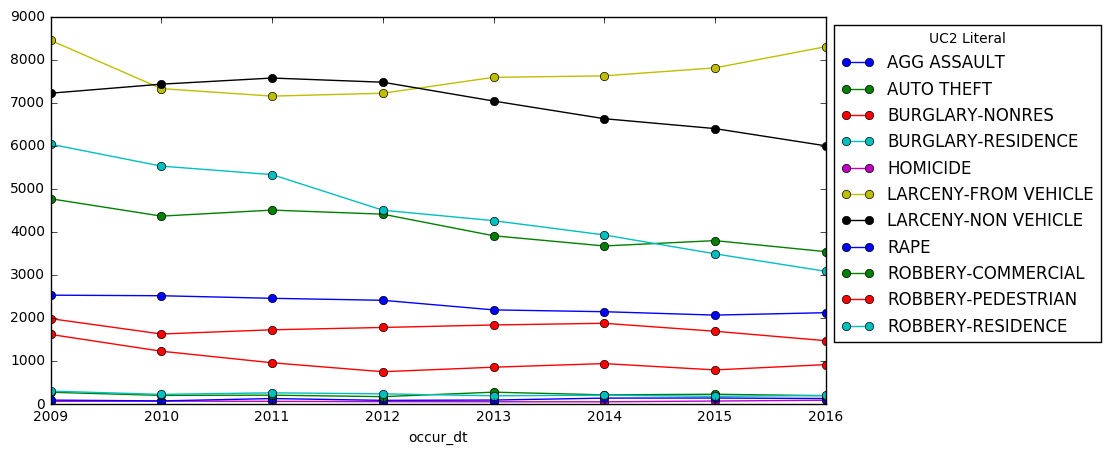

In [63]:
ax = ann_cr[ann_cr.index<"01/01/2017"].plot(figsize=(10,5), style='-o')
ax.get_legend().set_bbox_to_anchor((1, 1))

## Correlation In Number of Crimes Over Time

You can use the "corr" method in Pandas to find the correlation between columns of a dataframe. 

In [72]:
crime_corr = df_ct.corr()

In [73]:
crime_corr

UC2 Literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,RAPE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
UC2 Literal,,,,,,,,,,,
AGG ASSAULT,1.000000,0.576531,0.421596,0.542202,0.149337,0.338300,0.703525,-0.186406,0.107282,0.430136,0.245913
AUTO THEFT,0.576531,1.000000,0.533435,0.803201,0.120529,0.282402,0.713693,-0.291398,0.329893,0.619131,0.532972
BURGLARY-NONRES,0.421596,0.533435,1.000000,0.679169,0.112832,0.383798,0.397397,-0.106504,0.301352,0.449046,0.446097
BURGLARY-RESIDENCE,0.542202,0.803201,0.679169,1.000000,0.049407,0.134727,0.735370,-0.378922,0.366299,0.619963,0.602774
HOMICIDE,0.149337,0.120529,0.112832,0.049407,1.000000,0.190973,0.102213,0.027382,0.050653,0.120625,0.098739
LARCENY-FROM VEHICLE,0.338300,0.282402,0.383798,0.134727,0.190973,1.000000,0.264205,0.133064,0.344469,0.432473,0.152859
LARCENY-NON VEHICLE,0.703525,0.713693,0.397397,0.735370,0.102213,0.264205,1.000000,-0.289339,0.249787,0.614282,0.449193
RAPE,-0.186406,-0.291398,-0.106504,-0.378922,0.027382,0.133064,-0.289339,1.000000,-0.223143,-0.189692,-0.225600
ROBBERY-COMMERCIAL,0.107282,0.329893,0.301352,0.366299,0.050653,0.344469,0.249787,-0.223143,1.000000,0.518056,0.273413


Visualizing the correlation...

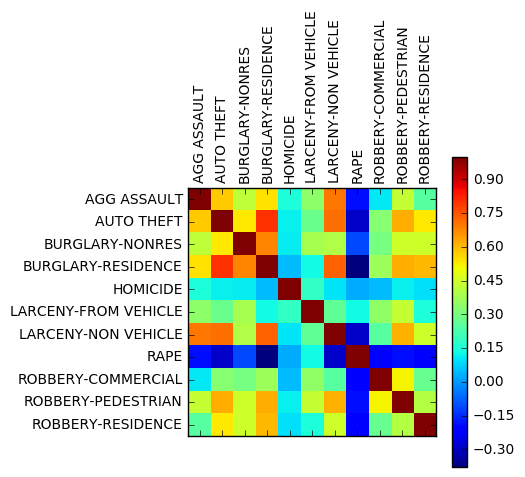

In [83]:
plt.matshow(crime_corr);
plt.yticks(range(len(crime_corr.columns)), crime_corr.columns);
plt.xticks(range(len(crime_corr.columns)), crime_corr.columns, rotation=90);
plt.colorbar();

# Crimes By Place

## Beats and Zones
The City of Atlanta is divided into 6 zones, each with 12 to 14 beats. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Atlanta_Police_Zones_-_Feb_2013.jpg/588px-Atlanta_Police_Zones_-_Feb_2013.jpg)

In [132]:
df['Zone'] = df['beat']//100
df['Year'] = df.occur_dt.apply(lambda x: x.year)

In [137]:
df_cp = df.pivot_table(index=["Year","Zone"], columns="UC2 Literal", values="offense_id", aggfunc=lambda x: np.count_nonzero(~np.isnan(x)))

In [160]:
df_cp = df_cp[np.logical_and([x >= 1 for x in zip(*df_cp.index.values)[1]], [x <= 6 for x in zip(*df_cp.index.values)[1]])].fillna(0)
df_cp.head(20)

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Year Zone                                                                   
2009 1.0           674.0      1045.0            262.0              1564.0   
     2.0           162.0       522.0            347.0               744.0   
     3.0           650.0      1256.0            266.0              1695.0   
     4.0           513.0      1078.0            282.0              1976.0   
     5.0           241.0       839.0            230.0               252.0   
     6.0           346.0       880.0            293.0              1163.0   
2010 1.0           777.0       771.0            204.0              1618.0   
     2.0           131.0       611.0            233.0               746.0   
     3.0           662.0      1077.0            234.0              1627.0   
     4.0           524.0      1129.0            240.0              1695.0   
     5.0           222.0       589.0            162.0               154.0   
     6.0           271.0       812.0            198.0               873.0   
2011 1.0           667.0       973.0            154.0              1457.0   
     2.0           145.0       545.0            175.0               643.0   
     3.0           681.0      1105.0            229.0              1645.0   
     4.0           547.0      1090.0            210.0              1680.0   
     5.0           225.0       647.0            112.0               166.0   
     6.0           246.0       845.0            114.0               818.0   
2012 1.0           656.0      1037.0            116.0              1284.0   
     2.0           158.0       487.0            168.0               699.0   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE  RAPE  \
Year Zone                                                                
2009 1.0         19.0                1102.0               1037.0  25.0   
     2.0          4.0                2203.0               2149.0  10.0   
     3.0         20.0                 841.0               1031.0  28.0   
     4.0         14.0                1148.0               1202.0  14.0   
     5.0          5.0                3333.0               1529.0  13.0   
     6.0          8.0                2342.0               1338.0   9.0   
2010 1.0         24.0                 855.0               1110.0   6.0   
     2.0          5.0                2152.0               1902.0  16.0   
     3.0         21.0                 854.0               1213.0  20.0   
     4.0         15.0                 971.0               1476.0  19.0   
     5.0          5.0                2632.0               1543.0   8.0   
     6.0         10.0                1714.0               1263.0  11.0   
2011 1.0         23.0                 861.0               1163.0  31.0   
     2.0          1.0                1662.0               1859.0  16.0   
     3.0         18.0                 928.0               1293.0  35.0   
     4.0         15.0                 969.0               1381.0  26.0   
     5.0          6.0                2526.0               1593.0  11.0   
     6.0         12.0                1642.0               1429.0  16.0   
2012 1.0         20.0                 886.0               1013.0  16.0   
     2.0          0.0                2123.0               1817.0   8.0   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
Year Zone                                                               
2009 1.0                   27.0               464.0               77.0  
     2.0                   67.0               120.0               42.0  
     3.0                   46.0               402.0               74.0  
     4.0                   50.0               370.0               65.0  
     5.0                   25.0               337.0               17.0  
     6.0                   66.0               323.0               34.0  
2010 1.0                   23.0               346.0               53.0  
     2.0           

In [194]:
## slicing on a multi-index
#  get data for 2009-2010, for zones 1-3 
df_cp.loc[(slice(2009,2010), slice(1,3)),:]

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Year Zone                                                                   
2009 1.0           674.0      1045.0            262.0              1564.0   
     2.0           162.0       522.0            347.0               744.0   
     3.0           650.0      1256.0            266.0              1695.0   
2010 1.0           777.0       771.0            204.0              1618.0   
     2.0           131.0       611.0            233.0               746.0   
     3.0           662.0      1077.0            234.0              1627.0   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE  RAPE  \
Year Zone                                                                
2009 1.0         19.0                1102.0               1037.0  25.0   
     2.0          4.0                2203.0               2149.0  10.0   
     3.0         20.0                 841.0               1031.0  28.0   
2010 1.0         24.0                 855.0               1110.0   6.0   
     2.0          5.0                2152.0               1902.0  16.0   
     3.0         21.0                 854.0               1213.0  20.0   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
Year Zone                                                               
2009 1.0                   27.0               464.0               77.0  
     2.0                   67.0               120.0               42.0  
     3.0                   46.0               402.0               74.0  
2010 1.0                   23.0               346.0               53.0  
     2.0                   44.0               116.0               30.0  
     3.0                   39.0               333.0               49.0

In [ ]:
## In-class exercise:
# Show all robbery data for 2011, 2013, and 2015, for zones 4-6 

In [ ]:
## In-class exercise:
# Count the total number of crimes in each zone

In [ ]:
## In-class exercise:
# Plot the number of pedestrian robberies in each zone in 2016

In [ ]:
## In-class exercise:
# What is the average annual number of crimes in each zone (for each type of crime)?
# Hint: use "groupby" with a "level" argument.

In [196]:
import sys
try:
    from osgeo import ogr, osr, gdal
except:
    sys.exit('ERROR: cannot find GDAL/OGR modules')